In [226]:
def print_results(grid_search, score):
    print("Ajustes de hiperparâmetros:")
    print(score + " do melhor modelo:", grid_search.best_score_)
    print("Melhores parâmetros:", grid_search.best_params_)

    cv_results = grid_search.cv_results_
    best_index = grid_search.best_index_

    std_score = cv_results['std_test_score'][best_index]
    fold_scores = [float(grid_search.cv_results_[f'split{i}_test_score'][best_index]) for i in range(10)]

    print("Cross-validation:")
    print(score + " dos folds:", fold_scores)
    print(score + " médio:", grid_search.best_score_)
    print("Desvio padrão:", std_score)

In [227]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cardiotocography = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X = cardiotocography.data.features 
y = cardiotocography.data.targets 
  
# metadata 
print(cardiotocography.metadata) 
  
# variable information 
print(cardiotocography.variables) 


{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

Para o NSP: normal=1; suspeito=2; patológico=3

In [228]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.concat([X, y], axis=1)

df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


# Vizualização dos dados

<Axes: xlabel='NSP', ylabel='Count'>

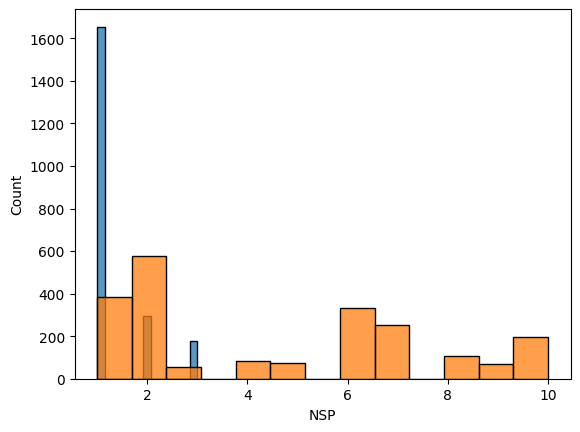

In [229]:
import seaborn as sns

sns.histplot(data=df, x="NSP")
sns.histplot(data=df, x="CLASS")

Não há uma distribuição normal e a base está bastante desbalanceada para o nosso target (NSP).

<Axes: xlabel='CLASS', ylabel='NSP'>

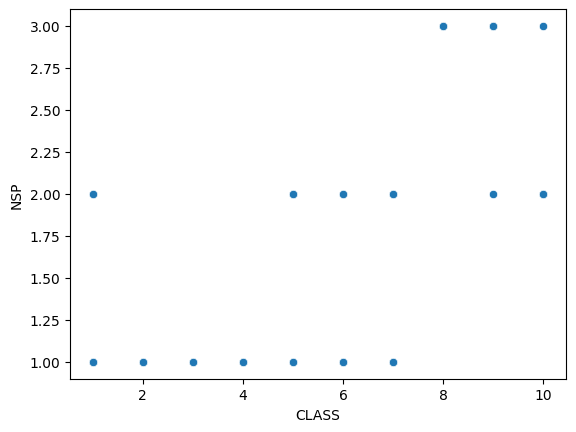

In [230]:
sns.scatterplot(x="CLASS", y="NSP", data=df)

In [231]:
import plotly.express as px

# Supondo que seu DataFrame df esteja definido corretamente
# df = pd.DataFrame(...)

correlation_matrix = df.corr(method='spearman')

fig = px.imshow(correlation_matrix,
                labels=dict(color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect="auto")

fig.update_layout(title='Mapa de Calor da Matriz de Correlação')

fig.show()


# KNN

In [232]:
X = df.drop(columns=['NSP'])
y = df['NSP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

A área sob a curva ROC deve ser um parâmetro interessante pois a base está desbalanceada. Por outro lado, a acurácia pode não refletir a realidade pelo mesmo motivo.

Os parâmetros dos algoritmos foram escolhidos de modo a levar em consideração o desbalanceamento da base.

In [233]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 8, 10, 12, 15, 18, 20, 21, 22, 25],
    'weights': ['uniform', 'distance']
}

## Área sob a curva ROC

In [234]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_train, y_train)

print_results(grid_search, 'ROC AUC')

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Ajustes de hiperparâmetros:
ROC AUC do melhor modelo: 0.9529277167344545
Melhores parâmetros: {'n_neighbors': 20, 'weights': 'distance'}
Cross-validation:
ROC AUC dos folds: [0.9244388160093583, 0.9311581404578877, 0.9604297919451872, 0.9558594794451871, 0.9668219418449198, 0.9142792591267002, 0.9760143584993053, 0.9643862899490505, 0.9690273274664197, 0.9668617626005306]
ROC AUC médio: 0.9529277167344545
Desvio padrão: 0.02038334632913688


Para o conjunto de teste:

In [235]:
best_model = grid_search.best_estimator_

# Probabilidade de cada classe para uma entrada
y_prob_bin = best_model.predict_proba(X_test)

# Criação dos dummies pois a curva roc usa dados binários
y_test_bin = label_binarize(y_test, classes=np.unique(y))

roc_auc = roc_auc_score(y_test_bin, y_prob_bin, multi_class='ovo', average='macro')

print("ROC AUC do melhor modelo no conjunto de teste:", roc_auc)


ROC AUC do melhor modelo no conjunto de teste: 0.9579178099604636


<Axes: >

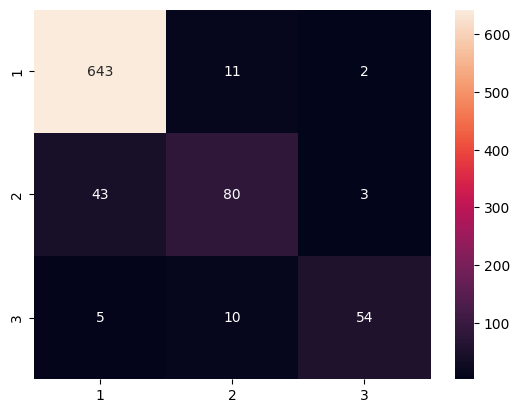

In [236]:
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])

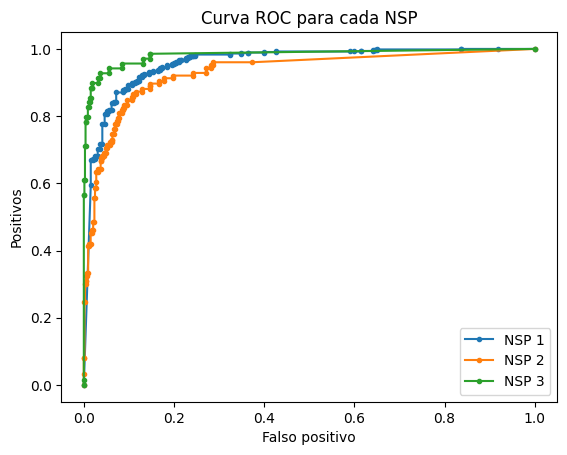

In [237]:
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_bin[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'NSP {i + 1}')

plt.xlabel('Falso positivo')
plt.ylabel('Positivos')
plt.title('Curva ROC para cada NSP')
plt.legend(loc='best')
plt.show()

## F1 Score

In [238]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print_results(grid_search, 'F1')

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Ajustes de hiperparâmetros:
F1 do melhor modelo: 0.9111074530307783
Melhores parâmetros: {'n_neighbors': 3, 'weights': 'distance'}
Cross-validation:
F1 dos folds: [0.8631391029715557, 0.8902176816239317, 0.9009958331340572, 0.9210809790334045, 0.921875, 0.9081096320760417, 0.9264202115388934, 0.9108272054695523, 0.933273360085445, 0.9351355243749012]
F1 médio: 0.9111074530307783
Desvio padrão: 0.02089790179133809


Para o conjunto de teste:

In [239]:
best_model = grid_search.best_estimator_

y_prob = best_model.predict(X_test)
f1 = f1_score(y_test, y_prob, average="weighted")

print("F1 do melhor modelo no conjunto de teste:", f1)


F1 do melhor modelo no conjunto de teste: 0.9234555022075417


<Axes: >

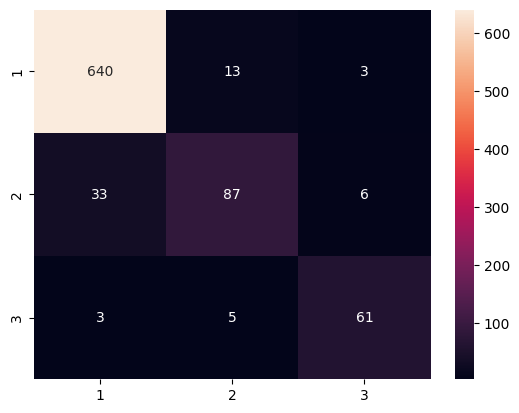

In [240]:
cm = confusion_matrix(y_test, y_prob, labels=[1, 2, 3])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])

## Acurácia

In [241]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print_results(grid_search, 'Acurácia')

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Ajustes de hiperparâmetros:
Acurácia do melhor modelo: 0.9145546259842521
Melhores parâmetros: {'n_neighbors': 3, 'weights': 'distance'}
Cross-validation:
Acurácia dos folds: [0.8671875, 0.8984375, 0.90625, 0.921875, 0.921875, 0.9133858267716536, 0.9291338582677166, 0.9133858267716536, 0.937007874015748, 0.937007874015748]
Acurácia médio: 0.9145546259842521
Desvio padrão: 0.01975634538496723


In [242]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Acurácia do melhor modelo no conjunto de teste:", accuracy)


Acurácia do melhor modelo no conjunto de teste: 0.9259694477085781


<Axes: >

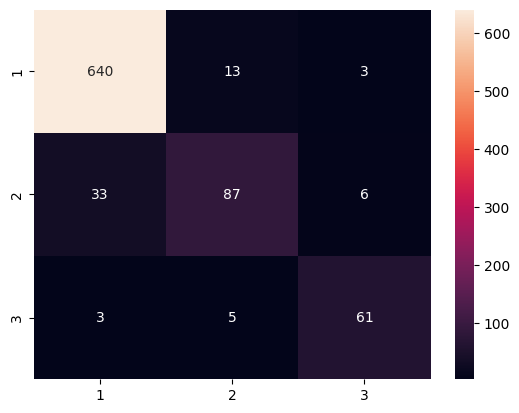

In [243]:
cm = confusion_matrix(y_test, y_prob, labels=[1, 2, 3])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])